<a href="https://colab.research.google.com/github/terrainthesky-hub/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Lesley_Rich_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:


#Confusion matrix is at the bottom!! **************

import pandas as pd
import os

from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(r'C:\Users\Lesley\Downloads\train_features.csv'), pd.read_csv(r'C:\Users\Lesley\Downloads\train_labels.csv'))

test = pd.read_csv(r'C:\Users\Lesley\Downloads\test_features.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape


((47520, 41), (11880, 41), (14358, 40))

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

In [0]:

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestClassifier


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

k = 3
score = cross_val_score(pipeline, X_train, y_train, cv=k,
                       scoring='accuracy')
print(f'Accuracy for {k} folds', score)

Accuracy for 3 folds [0.79261364 0.79955808 0.79236111]


In [0]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [23 ,24, 25, 26, 27, 28, 29, 30],
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__min_samples_split': [5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   18.1s remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.4s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   26.7s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   29.0s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   29.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.6s finished


In [0]:
pipeline.named_steps['randomforestclassifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pipeline = search.best_estimator_

In [0]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type',
                                      'waterpoint_t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15,
                                        max_features=0.3

In [0]:
print('Best hyperparameters', search.best_params_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.4105325914269071, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 11, 'randomforestclassifier__n_estimators': 29, 'simpleimputer__strategy': 'mean'}


In [0]:

sklearn.__version__

'0.22.2.post1'

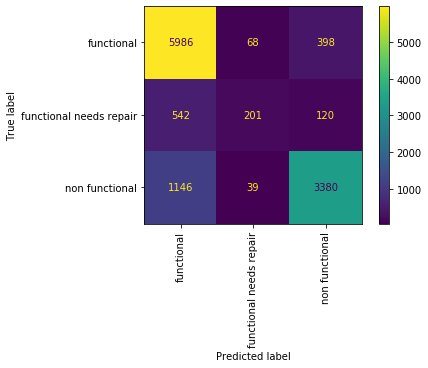

In [0]:
!pip install --user --upgrade scikit-learn

In [0]:
import sklearn

sklearn.__version__

'0.22.2.post1'

In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
path=r'C:\Users\Lesley\Desktop\Lambda\Lesley_Rich'
submission = test[['id']].copy()
submission['status_group'] = y_pred
# submission['status_group']
submission.to_csv(path+'DecisionTreeWaterPumpSub3.csv', index=False)

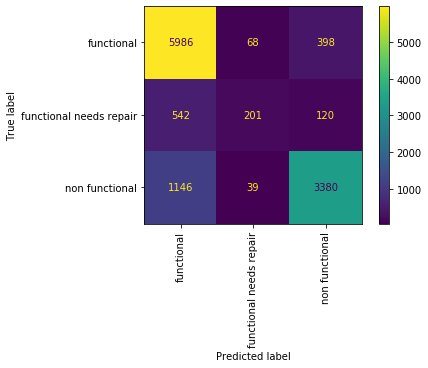

In [0]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
plt.show()

Requirement already up-to-date: tensorflow in c:\users\lesley\anaconda3\lib\site-packages (2.1.0)


AttributeError: module 'tensorflow' has no attribute 'Session'

AttributeError: module 'tensorflow' has no attribute 'Session'